In [1]:
import tensorflow as tf

In [2]:
TRAIN_TFRECORDS = './raw_data/train.tfrecords'
TEST_TFRECORDS = './raw_data/test.tfrecords'

In [3]:
def print_trainable_vals(sess):
    variables_names = [v.name for v in tf.trainable_variables()]
    values = sess.run(variables_names)
    for k, v in zip(variables_names, values):
        print('Variable: ', k, 'Shape: ', v.shape, 'Value: ', v)

In [4]:
class Model(object):
    
    def get_loss_acc(self, train_images, train_labels, reuse_variables=None):
        with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables):
            y_ = self.inference(train_images)
            y = tf.to_float(train_labels)
            y.set_shape([128, 10])
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                    labels=y, logits=y_))
            correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return loss, accuracy


    def get_weight_variable(self, shape):
        weights = tf.get_variable("weights", shape,
                                  initializer=tf.truncated_normal_initializer(
                                          stddev=0.1))
        return weights


    def inference(self, train_images):
        with tf.variable_scope('layer1'):
            w = self.get_weight_variable([784, 10])
            b = tf.get_variable("biases", [10],
                                initializer=tf.constant_initializer(0.0))
            y = tf.matmul(train_images, w) + b
        return y


    def train(self, file_names, global_step):
        with tf.variable_scope(tf.get_variable_scope()):
            samples = input_fn(file_names, 128)
            train_images, train_labels = samples
            loss, acc = self.get_loss_acc(train_images, train_labels)
            opt = tf.train.GradientDescentOptimizer(0.5)
            train_op = opt.minimize(loss, global_step=global_step)
            return train_op, loss, acc



In [5]:
def generate_parse_fn(batch_size):
    def read_examples(examples):
        features = {}
        features['label'] = tf.FixedLenFeature([], tf.int64)
        features['image_raw'] = tf.FixedLenFeature([], tf.string)
        features = tf.parse_example(examples, features)
        images = tf.decode_raw(features['image_raw'], tf.uint8)
        images.set_shape([batch_size, 784])
        images = tf.cast(images, tf.float32) * (1. / 255) - 0.5
        labels = features['label']
        one_hot_labels = tf.to_float(tf.one_hot(labels, 10, 1, 0))
        return images, one_hot_labels

    return read_examples


def input_fn(file_names, batch_size, epoch=None):
    _parse_fn = generate_parse_fn(batch_size)
    files = tf.data.Dataset.list_files(file_names)
    # number_of_cpu is the value of worker.vcore in xml file
    dataset = files.apply(tf.contrib.data.parallel_interleave(
            tf.data.TFRecordDataset,
            cycle_length=4 * 2))
    # prefetch will buffer the previos op and improve the performance
    dataset = dataset.prefetch(buffer_size=batch_size)
    # times: user defined
    dataset = dataset.shuffle(buffer_size=batch_size * 4)
    # buffer the shuffle op and improve the perfromance
    dataset = dataset.prefetch(buffer_size=batch_size)
    dataset = dataset.repeat(epoch)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(_parse_fn, num_parallel_calls=4)
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

In [6]:
global_step = tf.train.get_or_create_global_step()
model_a = Model()
train_op, loss, acc = model_a.train(TRAIN_TFRECORDS, global_step)
tf.get_variable_scope().reuse_variables()
model_b = Model()
_, valid_loss, valid_acc = model_b.train(TEST_TFRECORDS, global_step)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [7]:
print(tf.global_variables())

[<tf.Variable 'global_step:0' shape=() dtype=int64_ref>, <tf.Variable 'layer1/weights:0' shape=(784, 10) dtype=float32_ref>, <tf.Variable 'layer1/biases:0' shape=(10,) dtype=float32_ref>]


In [8]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
summary_writer = tf.summary.FileWriter('./summary', graph=tf.get_default_graph())
for __ in range(100):
    _, loss_val, acc_val, step = sess.run([train_op, loss, acc, global_step])
#     print('loss: ', loss_val, ' acc_val: ', acc_val, ' step: ', step)
print_trainable_vals(sess)
print('........................................training done........................................')
for __ in range(100):
    loss_val, acc_val, step = sess.run([valid_loss, valid_acc, global_step])
#     print('loss: ', loss_val, ' acc_val: ', acc_val, ' step: ', step) 

print_trainable_vals(sess)

Variable:  layer1/weights:0 Shape:  (784, 10) Value:  [[-0.18931071  0.10917468 -0.01489762 ...,  0.01861004 -0.05318324
  -0.03700953]
 [ 0.00220816  0.08144243 -0.09104109 ...,  0.11087343 -0.1180096
  -0.16221361]
 [-0.06938019 -0.10535911 -0.13202962 ...,  0.13303909 -0.10824373
   0.0093702 ]
 ..., 
 [-0.14936458  0.03727004  0.12935989 ...,  0.09951529 -0.08893839
  -0.04699423]
 [-0.0229484  -0.02519377  0.11148813 ..., -0.07025538  0.12198234
  -0.0863848 ]
 [-0.02752095  0.05686834  0.07670689 ...,  0.07225048  0.05731367
   0.04427886]]
Variable:  layer1/biases:0 Shape:  (10,) Value:  [ 0.03003306 -0.07823656  0.0515917   0.01901318 -0.03022525  0.00246576
  0.00515152 -0.02271323  0.0310733  -0.00815223]
........................................training done........................................
Variable:  layer1/weights:0 Shape:  (784, 10) Value:  [[-0.18931071  0.10917468 -0.01489762 ...,  0.01861004 -0.05318324
  -0.03700953]
 [ 0.00220816  0.08144243 -0.09104109 ...,  0

In [9]:
print(tf.global_variables())

[<tf.Variable 'global_step:0' shape=() dtype=int64_ref>, <tf.Variable 'layer1/weights:0' shape=(784, 10) dtype=float32_ref>, <tf.Variable 'layer1/biases:0' shape=(10,) dtype=float32_ref>]


In [9]:
# Graph is showed below.

# 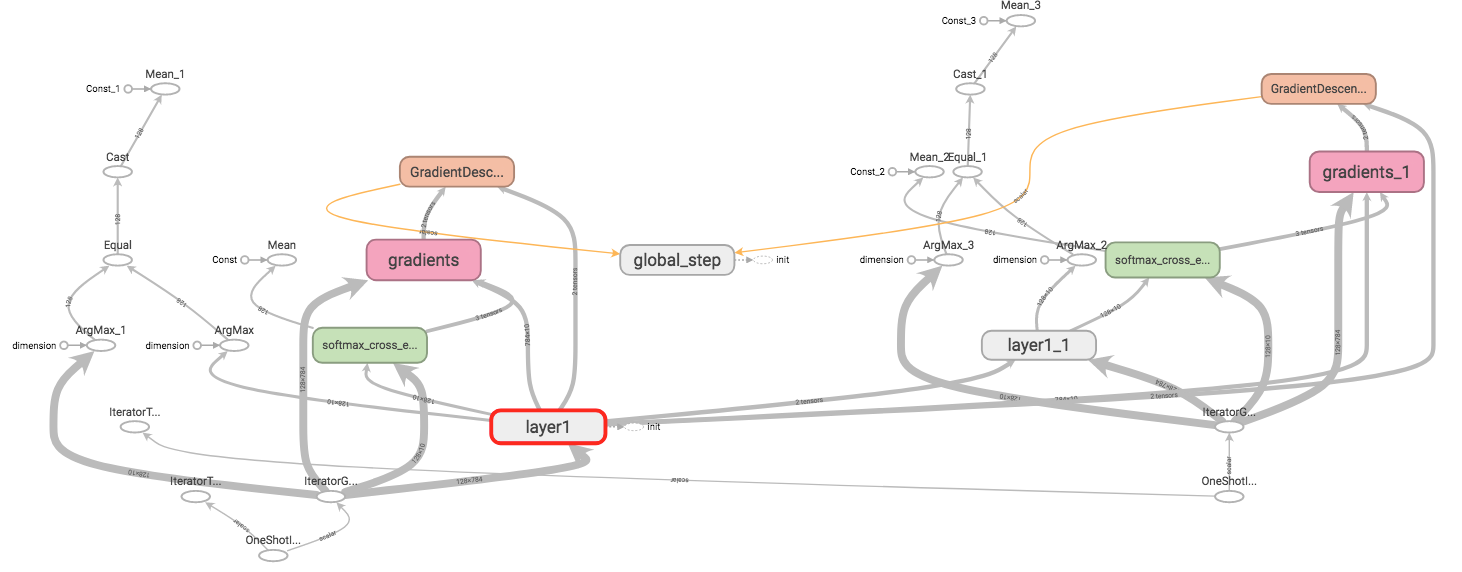